In [208]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore, f_oneway, ttest_ind
from statsmodels.stats.multicomp import pairwise_tukeyhsd

### Loading CSV into pandas dataframe for data cleaning

In [149]:
suicides = pd.read_csv('suicides.csv')

#### Initial look at the data for data cleaning

In [150]:
suicides.head()

,IndicatorCode,Indicator,ValueType,ParentLocationCode,ParentLocation,Location type,SpatialDimValueCode,Location,Period type,Period,...,FactValueUoM,FactValueNumericLowPrefix,FactValueNumericLow,FactValueNumericHighPrefix,FactValueNumericHigh,Value,FactValueTranslationID,FactComments,Language,DateModified
0,SDGSUICIDE,Crude suicide rates (per 100 000 population),text,AMR,Americas,Country,ATG,Antigua and Barbuda,Year,2019,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,EN,2021-07-06T04:00:00.000Z
1,SDGSUICIDE,Crude suicide rates (per 100 000 population),text,AMR,Americas,Country,ATG,Antigua and Barbuda,Year,2019,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,EN,2021-07-06T04:00:00.000Z
2,SDGSUICIDE,Crude suicide rates (per 100 000 population),text,AMR,Americas,Country,ATG,Antigua and Barbuda,Year,2019,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,EN,2021-07-06T04:00:00.000Z
3,SDGSUICIDE,Crude suicide rates (per 100 000 population),text,AMR,Americas,Country,ATG,Antigua and Barbuda,Year,2019,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,EN,2021-07-06T04:00:00.000Z
4,SDGSUICIDE,Crude suicide rates (per 100 000 population),text,AMR,Americas,Country,ATG,Antigua and Barbuda,Year,2019,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,EN,2021-07-06T04:00:00.000Z


#### Remove metadata columns and missing data to create a usable dataset for EDA

In [151]:
# Check columns to identify which columns to drop that contain missing data over 60%
suicides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4392 entries, 0 to 4391
Data columns (total 34 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   IndicatorCode               4392 non-null   object 
 1   Indicator                   4392 non-null   object 
 2   ValueType                   4392 non-null   object 
 3   ParentLocationCode          4392 non-null   object 
 4   ParentLocation              4392 non-null   object 
 5   Location type               4392 non-null   object 
 6   SpatialDimValueCode         4392 non-null   object 
 7   Location                    4392 non-null   object 
 8   Period type                 4392 non-null   object 
 9   Period                      4392 non-null   int64  
 10  IsLatestYear                4392 non-null   bool   
 11  Dim1 type                   4392 non-null   object 
 12  Dim1                        4392 non-null   object 
 13  Dim1ValueCode               4392 

In [152]:
# Drop missing data columns to clean the dataset
suicides.dropna(axis='columns', how='all', inplace=True)
suicides.head()

,IndicatorCode,Indicator,ValueType,ParentLocationCode,ParentLocation,Location type,SpatialDimValueCode,Location,Period type,Period,...,Dim1 type,Dim1,Dim1ValueCode,Dim2 type,Dim2,Dim2ValueCode,FactValueNumeric,Value,Language,DateModified
0,SDGSUICIDE,Crude suicide rates (per 100 000 population),text,AMR,Americas,Country,ATG,Antigua and Barbuda,Year,2019,...,Sex,Both sexes,BTSX,Age Group,15-24 years,YEARS15-24,0.0,0.0,EN,2021-07-06T04:00:00.000Z
1,SDGSUICIDE,Crude suicide rates (per 100 000 population),text,AMR,Americas,Country,ATG,Antigua and Barbuda,Year,2019,...,Sex,Both sexes,BTSX,Age Group,25-34 years of age,YEARS25-34,0.0,0.0,EN,2021-07-06T04:00:00.000Z
2,SDGSUICIDE,Crude suicide rates (per 100 000 population),text,AMR,Americas,Country,ATG,Antigua and Barbuda,Year,2019,...,Sex,Both sexes,BTSX,Age Group,35-44 years of age,YEARS35-44,0.0,0.0,EN,2021-07-06T04:00:00.000Z
3,SDGSUICIDE,Crude suicide rates (per 100 000 population),text,AMR,Americas,Country,ATG,Antigua and Barbuda,Year,2019,...,Sex,Both sexes,BTSX,Age Group,45-54 years,YEARS45-54,0.0,0.0,EN,2021-07-06T04:00:00.000Z
4,SDGSUICIDE,Crude suicide rates (per 100 000 population),text,AMR,Americas,Country,ATG,Antigua and Barbuda,Year,2019,...,Sex,Both sexes,BTSX,Age Group,65-74 years,YEARS65-74,0.0,0.0,EN,2021-07-06T04:00:00.000Z


In [153]:
#Check values of Dim2ValueCode to determine how to split the strings
suicides.Dim2ValueCode.value_counts()

YEARS15-24     549
YEARS25-34     549
YEARS35-44     549
YEARS45-54     549
YEARS65-74     549
YEARS75-84     549
YEARS85PLUS    549
YEARS55-64     549
Name: Dim2ValueCode, dtype: int64

In [154]:
#Replace YEARS with "" to prep for a column split
suicides['Dim2ValueCode'] = suicides['Dim2ValueCode'].replace('YEARS', '', regex=True)
print(suicides['Dim2ValueCode'].value_counts())

#Check dataframe for accurate split and new columns
suicides.head()

15-24     549
25-34     549
35-44     549
45-54     549
65-74     549
75-84     549
85PLUS    549
55-64     549
Name: Dim2ValueCode, dtype: int64


,IndicatorCode,Indicator,ValueType,ParentLocationCode,ParentLocation,Location type,SpatialDimValueCode,Location,Period type,Period,...,Dim1 type,Dim1,Dim1ValueCode,Dim2 type,Dim2,Dim2ValueCode,FactValueNumeric,Value,Language,DateModified
0,SDGSUICIDE,Crude suicide rates (per 100 000 population),text,AMR,Americas,Country,ATG,Antigua and Barbuda,Year,2019,...,Sex,Both sexes,BTSX,Age Group,15-24 years,15-24,0.0,0.0,EN,2021-07-06T04:00:00.000Z
1,SDGSUICIDE,Crude suicide rates (per 100 000 population),text,AMR,Americas,Country,ATG,Antigua and Barbuda,Year,2019,...,Sex,Both sexes,BTSX,Age Group,25-34 years of age,25-34,0.0,0.0,EN,2021-07-06T04:00:00.000Z
2,SDGSUICIDE,Crude suicide rates (per 100 000 population),text,AMR,Americas,Country,ATG,Antigua and Barbuda,Year,2019,...,Sex,Both sexes,BTSX,Age Group,35-44 years of age,35-44,0.0,0.0,EN,2021-07-06T04:00:00.000Z
3,SDGSUICIDE,Crude suicide rates (per 100 000 population),text,AMR,Americas,Country,ATG,Antigua and Barbuda,Year,2019,...,Sex,Both sexes,BTSX,Age Group,45-54 years,45-54,0.0,0.0,EN,2021-07-06T04:00:00.000Z
4,SDGSUICIDE,Crude suicide rates (per 100 000 population),text,AMR,Americas,Country,ATG,Antigua and Barbuda,Year,2019,...,Sex,Both sexes,BTSX,Age Group,65-74 years,65-74,0.0,0.0,EN,2021-07-06T04:00:00.000Z


In [155]:
# Identify columns to remove to create a clean dataset for EDA
suicide_columns = suicides.columns.to_list()
print(suicide_columns)

#Add desired columns to a list
desired_columns = ['ParentLocation', 'Location', 'Period', 'Value', 'Dim1', 'Dim2ValueCode']

['IndicatorCode', 'Indicator', 'ValueType', 'ParentLocationCode', 'ParentLocation', 'Location type', 'SpatialDimValueCode', 'Location', 'Period type', 'Period', 'IsLatestYear', 'Dim1 type', 'Dim1', 'Dim1ValueCode', 'Dim2 type', 'Dim2', 'Dim2ValueCode', 'FactValueNumeric', 'Value', 'Language', 'DateModified']


### Chosing columns for EDA (Metadata)

-- Metadata on columns for Crude Suicide Rates (per 100 000 population)-- <br>
ParentLocation = Region ('Americas', 'Western Pacific', 'Europe', 'Africa', 'South-East Asia', 'Eastern Mediterranean') <br>
Location = Country data surveyed (Multitude) <br>
Period = Year data collected <br>
Value = Crude Suicide Rates (per 100 000 population) <br>
Sex = Gender (Male/Female/Both) <br>
AgeMin / AgeMax = Age ranges for data (Assume 100 yrs old is max)

In [156]:
suicides_clean = suicides[desired_columns].rename(columns={'Dim1': 'Sex', 'Dim2ValueCode': 'AgeRange'})
suicides_clean.head()

,ParentLocation,Location,Period,Value,Sex,AgeRange
0,Americas,Antigua and Barbuda,2019,0.0,Both sexes,15-24
1,Americas,Antigua and Barbuda,2019,0.0,Both sexes,25-34
2,Americas,Antigua and Barbuda,2019,0.0,Both sexes,35-44
3,Americas,Antigua and Barbuda,2019,0.0,Both sexes,45-54
4,Americas,Antigua and Barbuda,2019,0.0,Both sexes,65-74


In [157]:
# Adjust Sex column where Both sexes = Both for simplicity
suicides_clean['Sex'] = suicides_clean.Sex.apply(lambda sex: 'Both' if sex == 'Both sexes' else sex)

# Check for correct changes
suicides_clean.Sex.value_counts()

Both      1464
Female    1464
Male      1464
Name: Sex, dtype: int64

In [158]:
# Remove the redundant Both category in sexes for future EDA (Compare Male to Female only)
suicides_clean = suicides_clean[suicides_clean.Sex != 'Both']
suicides_clean.head()

,ParentLocation,Location,Period,Value,Sex,AgeRange
7,Americas,Antigua and Barbuda,2019,0.0,Female,15-24
8,Americas,Antigua and Barbuda,2019,0.0,Female,25-34
9,Americas,Antigua and Barbuda,2019,0.0,Female,35-44
10,Americas,Antigua and Barbuda,2019,0.0,Female,45-54
11,Americas,Antigua and Barbuda,2019,0.0,Female,65-74


### Check/adjust data types to complete data cleaning

In [159]:
suicides_clean.dtypes

ParentLocation     object
Location           object
Period              int64
Value             float64
Sex                object
AgeRange           object
dtype: object

In [160]:
suicides_clean.isnull().sum()

ParentLocation    0
Location          0
Period            0
Value             0
Sex               0
AgeRange          0
dtype: int64

### Univariate Data Profiling

Initial summary statistics to get a general picture of the data. <br>
Also to generate questions to answer using the data and potential model building

In [161]:
suicides_clean.describe()

,Period,Value
count,2928.0,2928.000000
mean,2019.0,24.101752
std,0.0,48.511200
min,2019.0,0.000000
25%,2019.0,4.227500
50%,2019.0,10.080000
75%,2019.0,23.395000
max,2019.0,646.000000


##### Mean suicide rates by region

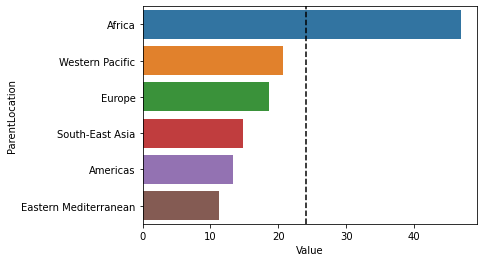

In [162]:
# Mean suicides rates including all regions to serve as a reference point in the bar graph 
suicide_rates_mean = suicides_clean.Value.mean()

# Sort values for each region in desending order for ordered barplot
suicides_means_sorted = suicides_clean.groupby(by='ParentLocation', as_index=False).Value.mean().sort_values(by='Value', ascending=False)

# Visualization of the means to identify trends
sns.barplot(data=suicides_means_sorted, y='ParentLocation', x='Value')
plt.axvline(suicide_rates_mean, linestyle='--', color='black')

Africa mean suicide rates exceed all other regions and the total average by nearly double or more<br>

##### Median suicide rates by region

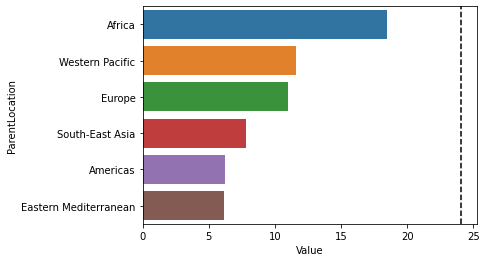

In [163]:
# Median suicides rates including all regions to serve as a reference point in the bar graph 
suicide_rates_median = suicides_clean.Value.median()

# Sort values for each region in desending order for ordered barplot
suicides_median_sorted = suicides_clean.groupby(by='ParentLocation', as_index=False).Value.median().sort_values(by='Value', ascending=False)

# Visualization of the medians to identify trends
sns.barplot(data=suicides_median_sorted, y='ParentLocation', x='Value')
plt.axvline(suicide_rates_mean, linestyle='--', color='black')

Africa median suicide rates exceeds all other regions but not to the extent of the mean suicide rates<br>
Median is more resistant summary statistic to outliers which can explain the differences<br>
The presence of outliers will have to be explored with histograms/boxplots

<AxesSubplot:xlabel='Value', ylabel='Count'>

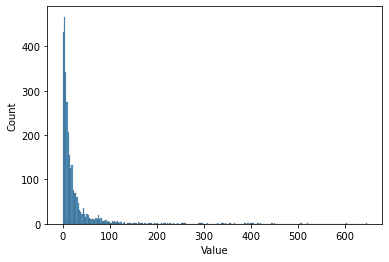

In [164]:
#Histogram to visualize the spread of the suicide rates of all countries together
sns.histplot(data=suicides_clean, x='Value')

Coarse search reveals right skewed spread due to outliers (All countries) <br>

#### Are the suicide rates skewed for each region?

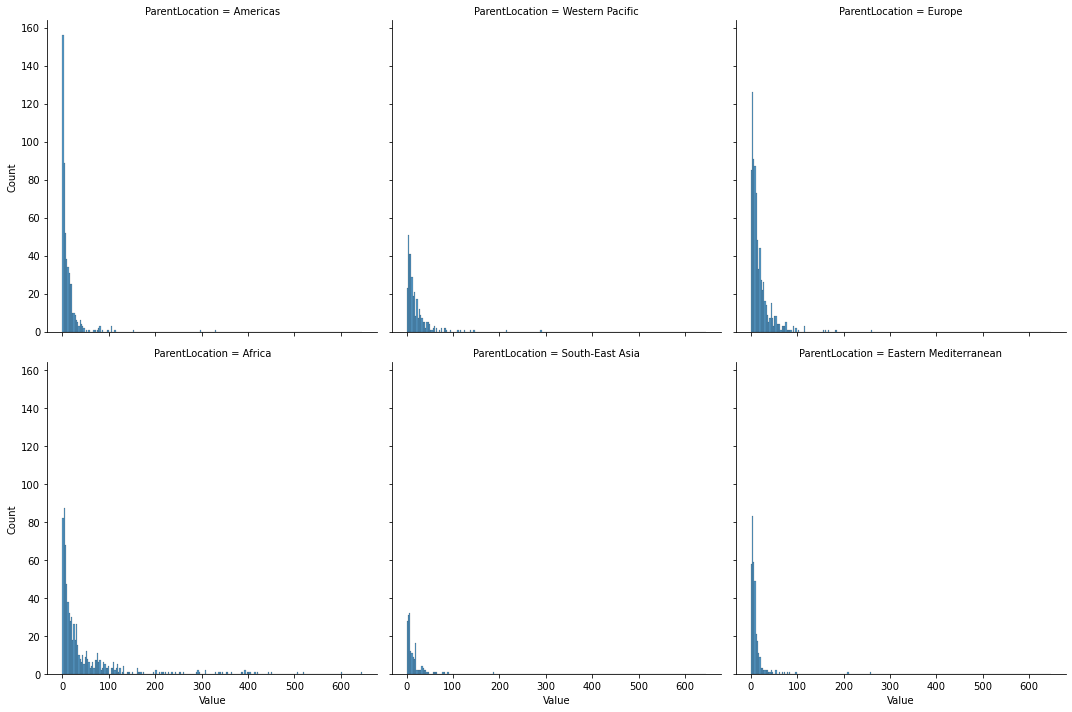

In [165]:
#Figure level plot to aid visualization
sns.displot(data=suicides_clean, x='Value', col='ParentLocation', col_wrap=3)

Spread is still right skewed at the region level <br>
An indepth look at the IQR, median and range is needed

<AxesSubplot:xlabel='Value', ylabel='ParentLocation'>

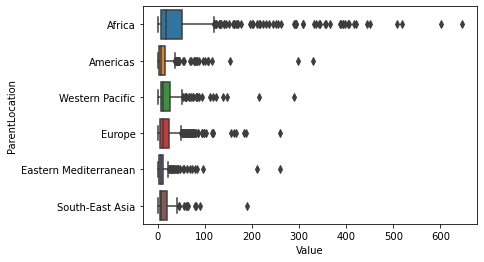

In [166]:
suicides_clean.sort_values(by='Value', ascending=False, inplace=True)
sns.boxplot(data=suicides_clean, x='Value', y='ParentLocation')

Africa appears to have the largest range for suicide rates <br>
The IQR and median is higher than other regions as well

#### Distribution of Suicide Rates by Age Range

<AxesSubplot:xlabel='Value', ylabel='AgeRange'>

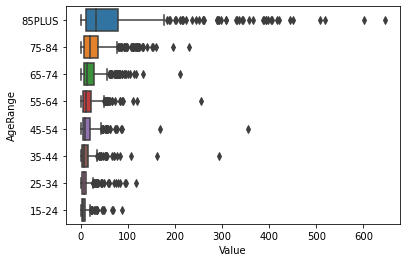

In [167]:
suicides_clean.sort_values(by='AgeRange', ascending=False, inplace=True)
sns.boxplot(data=suicides_clean, x='Value', y='AgeRange')

85Plus age range has the largest range and median<br>
All of the age ranges have a right skewed distribution that will need to be transformed for future EDA

#### Distribution of Suicide Rates by Sex

<AxesSubplot:xlabel='Value', ylabel='Sex'>

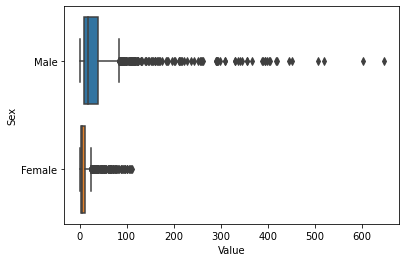

In [168]:
suicides_clean.sort_values(by='Sex', ascending=False, inplace=True)
sns.boxplot(data=suicides_clean, x='Value', y='Sex')

<AxesSubplot:xlabel='Value', ylabel='Count'>

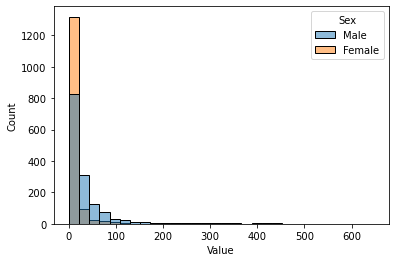

In [169]:
# Histogram to view overlap of suicide rates of males vs females
sns.histplot(data=suicides_clean, x='Value', hue='Sex', bins=30)

Female distribution is concentrated closer to zero<br>
Males have a larger distribution and is skewed more heavily to the right than females

### Are the suicide rates for each region statiscally different?<br>
Null Hypothesis - The suicides rates means do not differ between regions<br>
Alt Hypothesis - Suicide rates are not equal between the regions

#### One way ANOVA Test<br>

##### ANOVA Assumptions<br>
--- Taken from codecademy ---<br>
(1) All observations should be independently and randomly sampled<br>
(2) The standard deviations of the groups should be equal<br>
(3) The data should be normally distributed or the sample size should be large<br>
(4) The groups created by the categorical variable should be independent<br>
-------------------------------- <br>
Signifcance Threshold = 0.05

In [170]:
# Checking for sample sizes between regions. Ideally sample sizes between categories should be close
suicides_clean.ParentLocation.value_counts()

Europe                   800
Africa                   752
Americas                 528
Eastern Mediterranean    336
Western Pacific          336
South-East Asia          176
Name: ParentLocation, dtype: int64

In [171]:
#Calculating std of each region to check if assumption 2 is met (std of groups should be equal)
regions = list(suicides_clean.ParentLocation.unique())

for region in regions:
    print(region, suicides_clean[suicides_clean.ParentLocation == region].Value.std())

Africa 81.88833938903966
Eastern Mediterranean 21.408601472135324
Europe 23.75806209056134
Americas 25.816426257329468
Western Pacific 28.42654560254181
South-East Asia 20.39371886463747


#### Zscore Normalization

In [172]:
#Use the zscore of the value column to reduce the effects of outliers on assumptions 2 and 3
zscore_standard_threshold = 3
suicides_zscored = suicides_clean[(np.abs(zscore(suicides_clean.Value)) < zscore_standard_threshold)]
suicides_zscored.ParentLocation.value_counts()

Europe                   797
Africa                   709
Americas                 526
Eastern Mediterranean    334
Western Pacific          334
South-East Asia          175
Name: ParentLocation, dtype: int64

In [173]:
#Checking std difference after zscore to meet ANOVA assumption 2
for region in regions:
    print(region, suicides_zscored[suicides_zscored.ParentLocation == region].Value.std())

Africa 33.8801017502261
Eastern Mediterranean 12.522337104637886
Europe 20.587859783581244
Americas 17.963356751378484
Western Pacific 21.930853317338745
South-East Asia 15.621246053459567


<AxesSubplot:xlabel='Value', ylabel='ParentLocation'>

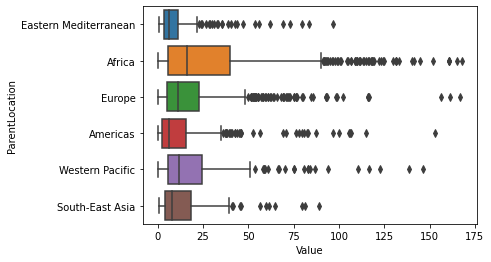

In [174]:
#Visualization of zcored distribution for assumption 3
sns.boxplot(data=suicides_zscored, x='Value', y='ParentLocation')

Zscored boxplot of suicide rates  ----<br> 
It's easier to see Africa has a larger median, IQR and range<br>
The Eastern Mediterranean appears to have the lowest suicide rates

#### Zscore normalization ANOVA Test

In [175]:
#Dividing suicide rates by region to prep for anova test
suicide_regions = {region:suicides_zscored.Value[suicides_zscored.ParentLocation == region] for region in regions}
print(suicide_regions.keys())

dict_keys(['Africa', 'Eastern Mediterranean', 'Europe', 'Americas', 'Western Pacific', 'South-East Asia'])


In [176]:
#Anova test to determine if the pval is significant
fstat, pval = f_oneway(suicide_regions['Americas'], suicide_regions['Europe'], suicide_regions['Africa'],
                       suicide_regions['South-East Asia'], suicide_regions['Eastern Mediterranean'], suicide_regions['Western Pacific'])
print(pval)

2.613614708541573e-50


In [177]:
#Tukey's Range Test to determine which pairings are significant
sig_threshold = 0.05
tukey_results = pairwise_tukeyhsd(suicides_zscored.Value, suicides_zscored.ParentLocation, sig_threshold)
print(tukey_results)

                Multiple Comparison of Means - Tukey HSD, FWER=0.05                 
        group1                group2        meandiff p-adj   lower    upper   reject
------------------------------------------------------------------------------------
               Africa              Americas -17.4895    0.0 -21.3336 -13.6454   True
               Africa Eastern Mediterranean -19.8074    0.0 -24.2407 -15.3742   True
               Africa                Europe -11.7295    0.0 -15.1781   -8.281   True
               Africa       South-East Asia -15.8946    0.0 -21.5331 -10.2562   True
               Africa       Western Pacific -10.3511    0.0 -14.7844  -5.9179   True
             Americas Eastern Mediterranean  -2.3179 0.7184  -6.9916   2.3558  False
             Americas                Europe   5.7599 0.0002   2.0073   9.5126   True
             Americas       South-East Asia   1.5948 0.9709  -4.2345   7.4242  False
             Americas       Western Pacific   7.1383 0.0002   2.4

##### Africa is significantly different from every other region<br>
Region pairs that are not significantly different are: (pval >= 0.05)<br>
Americas - Eastern Mediterranean<br>
Americas - South-East Asia<br>
Eastern Mediterranean - South-East Asia<br>
Europe - South-East Asia<br>
Europe - Western Pacific<br>


The Zscored Suicide Rates ANOVA test results should be used with caution. Assumption 2 and 3 are not closely followed even after the removal of outliers.<br>
A Natural Log (ln) standarization of suicide rates should be tested for comparison

### Natural Log Transformation

Useful to transform right skewed data into a more normal distribution<br>
Cannot be used with negative values or zero as the ln of a negative = undefined

In [178]:
# Copy to perform ln transformation to preserve clean dataset
suicides_ln = suicides_clean.copy()

#Remove all suicide rates <=0 to prep for transformation
suicides_ln = suicides_ln[suicides_ln.Value > 0]

# Check number of records removed
records_removed = len(suicides_clean) - len(suicides_ln)
print(f'{records_removed} records removed')

# ln transformation for data profiling and ANOVA test
suicides_ln['Value'] = np.log(suicides_ln['Value'])
suicides_ln.head()

76 records removed


,ParentLocation,Location,Period,Value,Sex,AgeRange
3716,Africa,Mozambique,2019,6.470800,Male,85PLUS
3543,Eastern Mediterranean,Egypt,2019,1.850028,Male,45-54
1850,Africa,Rwanda,2019,3.077773,Male,45-54
3688,Europe,Russian Federation,2019,4.109726,Male,45-54
2056,Americas,Cuba,2019,3.258097,Male,45-54


#### Suicide Rate by Region (ln)

In [179]:
#Calculating std of each region to check if assumption 2 is met (std of groups should be equal)
for region in regions:
    print(region, suicides_ln[suicides_ln.ParentLocation == region].Value.std())

Africa 1.4353496846771694
Eastern Mediterranean 0.9898673194838149
Europe 1.0579498195665975
Americas 1.1493583883434226
Western Pacific 1.0090082359658819
South-East Asia 1.1178408742569959


<AxesSubplot:xlabel='Value', ylabel='ParentLocation'>

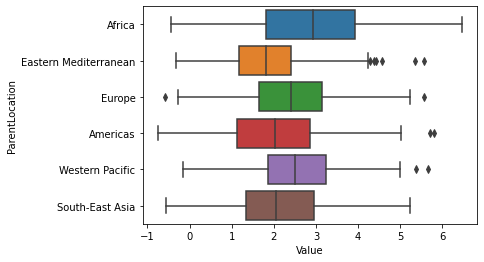

In [180]:
#Visualization of ln transformation distribution for assumption 3
sns.boxplot(data=suicides_ln, x='Value', y='ParentLocation')

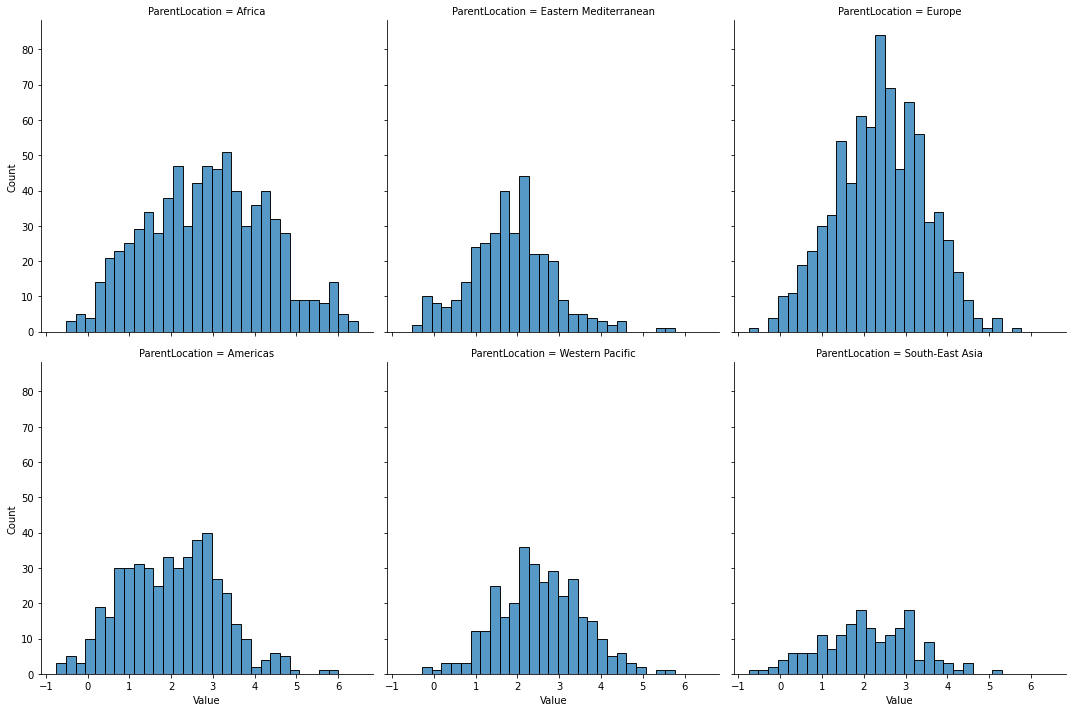

In [181]:
sns.displot(data=suicides_ln, x='Value', col='ParentLocation', col_wrap=3)

Distribution for each region normalized compared to clean dataset<br>
Suicide Rates = e^Value

#### Suicide Rate by Age Range(ln)

In [182]:
#Calculating std of each age range to check if assumption 2 is met (std of groups should be equal)
ages = list(suicides_ln.AgeRange.unique())

for age in ages:
    print(age, suicides_ln[suicides_clean.AgeRange == age].Value.std())

85PLUS 1.3438960037422298
45-54 1.0476237409418763
55-64 1.0888552278520494
35-44 1.0313104189269295
65-74 1.0966337880893087
15-24 0.928128257896598
25-34 0.9924794295946479
75-84 1.1435960545769888


C:\Users\Christian\AppData\Local\Temp\ipykernel_7444\393892421.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(age, suicides_ln[suicides_clean.AgeRange == age].Value.std())


<AxesSubplot:xlabel='Value', ylabel='AgeRange'>

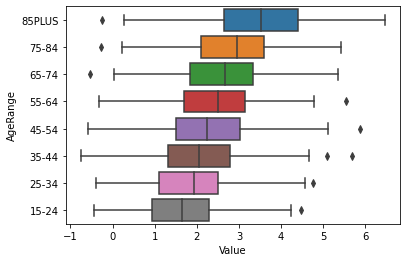

In [190]:
#Visualization of ln transformation distribution for assumption 3
suicides_ln.sort_values(by='AgeRange', ascending=False, inplace=True)
sns.boxplot(data=suicides_ln, x='Value', y='AgeRange')

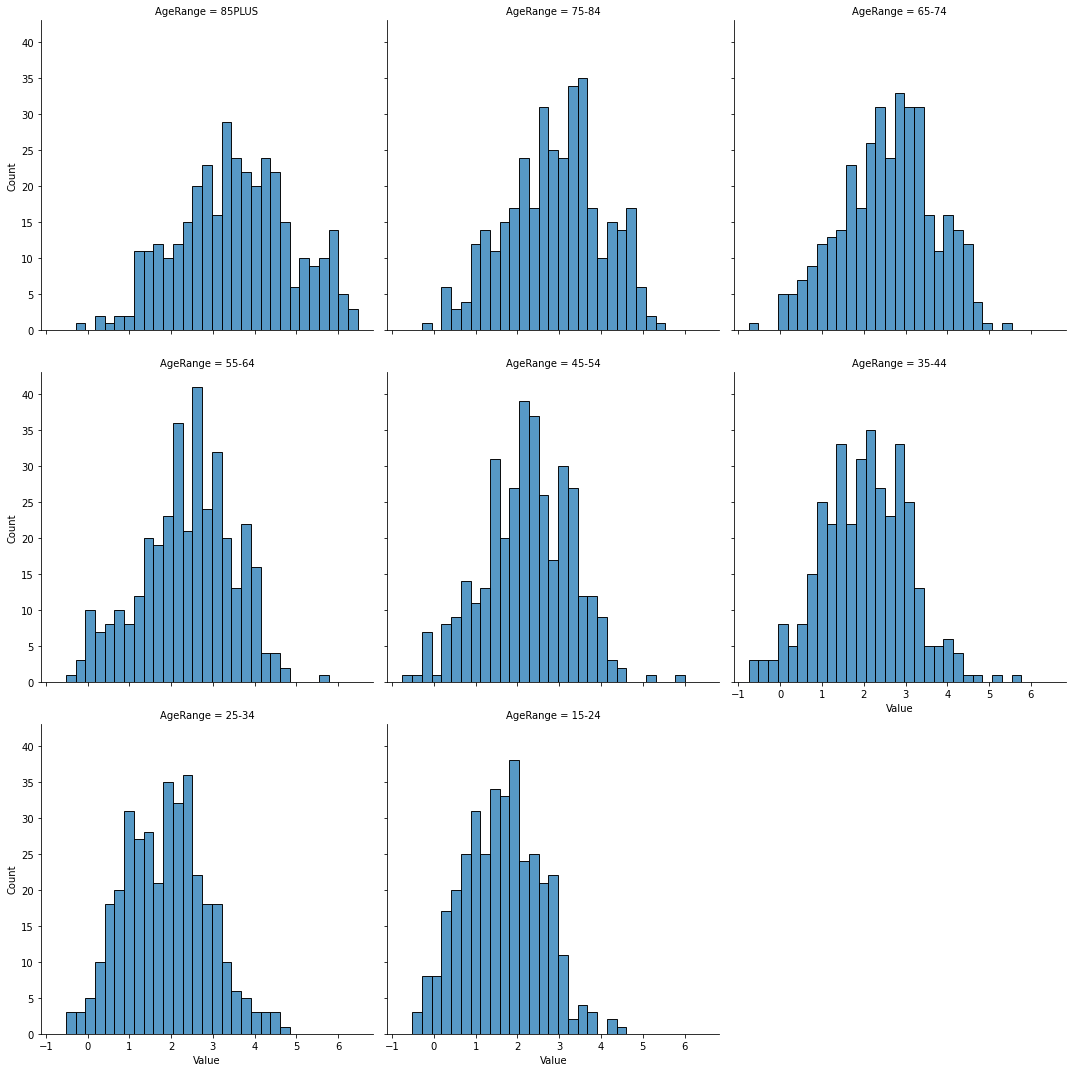

In [191]:
sns.displot(data=suicides_ln, x='Value', col='AgeRange', col_wrap=3)

Age range distributions are normalized<br>
Suicide Rates = e^Value

#### Suicide Rate by Sex(ln)

In [192]:
#Calculating std of each sex to check if assumption 2 is met (std of groups should be equal)
sexes = list(suicides_ln.Sex.unique())

for sex in sexes:
    print(sex, suicides_ln[suicides_clean.Sex == sex].Value.std())

Male 1.0355875525978842
Female 1.0405803690308915


C:\Users\Christian\AppData\Local\Temp\ipykernel_7444\3523642688.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(sex, suicides_ln[suicides_clean.Sex == sex].Value.std())


<AxesSubplot:xlabel='Value', ylabel='Sex'>

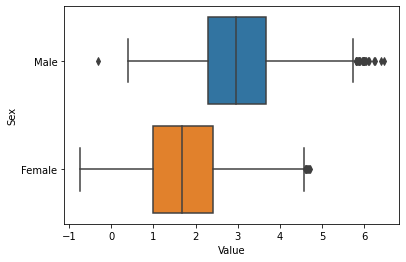

In [193]:
#Visualization of ln transformation distribution for assumption 3
suicides_ln.sort_values(by='Sex', ascending=False, inplace=True)
sns.boxplot(data=suicides_ln, x='Value', y='Sex')

<AxesSubplot:xlabel='Value', ylabel='Count'>

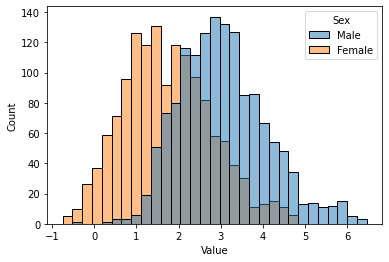

In [196]:
# Histogram to view overlap of suicide rates of males vs females
sns.histplot(data=suicides_ln, x='Value', hue='Sex')

Slightly left skewed distributions<br>
Female distribution centered around Suicide Rates = e^1.5<br>
Male distribution centered around Suicide Rates = e^3

### Natural log transformation ANOVA Tests

#### ANOVA Test Suicide Rates by Region

In [184]:
#Dividing suicide rates by region to prep for anova test
suicide_regions2 = {region:suicides_ln.Value[suicides_ln.ParentLocation == region] for region in regions}
print(suicide_regions2.keys())

dict_keys(['Africa', 'Eastern Mediterranean', 'Europe', 'Americas', 'Western Pacific', 'South-East Asia'])


In [185]:
#Anova test to determine if the pval is significant
fstat, pval = f_oneway(suicide_regions2['Americas'], suicide_regions2['Europe'], suicide_regions2['Africa'],
                       suicide_regions2['South-East Asia'], suicide_regions2['Eastern Mediterranean'], suicide_regions2['Western Pacific'])
print(pval)

1.1753090998849108e-52


In [203]:
#Tukey's Range Test to determine which pairings are significant
sig_threshold = 0.05
tukey_results_ln = pairwise_tukeyhsd(suicides_ln.Value, suicides_ln.ParentLocation, sig_threshold)
print(tukey_results_ln)

               Multiple Comparison of Means - Tukey HSD, FWER=0.05                
        group1                group2        meandiff p-adj   lower   upper  reject
----------------------------------------------------------------------------------
               Africa              Americas  -0.8569   -0.0 -1.0539 -0.6598   True
               Africa Eastern Mediterranean  -1.0334   -0.0 -1.2533 -0.8135   True
               Africa                Europe  -0.4773   -0.0 -0.6479 -0.3066   True
               Africa       South-East Asia    -0.78   -0.0 -1.0606 -0.4994   True
               Africa       Western Pacific   -0.335 0.0003  -0.557  -0.113   True
             Americas Eastern Mediterranean  -0.1766 0.2855 -0.4159  0.0628  False
             Americas                Europe   0.3796    0.0  0.1846  0.5746   True
             Americas       South-East Asia   0.0769 0.9768 -0.2192  0.3729  False
             Americas       Western Pacific   0.5219    0.0  0.2806  0.7631   True
East

##### Africa is significantly different from every other region<br>
Region pairs that are not significantly different are: (pval >= 0.05)<br>
Americas - Eastern Mediterranean<br>
Americas - South-East Asia<br>
Eastern Mediterranean - South-East Asia<br>
Europe - South-East Asia<br>
Europe - Western Pacific<br>
Natural Log transformation ANOVA test supports the results from the zscored normalized ANOVA test

#### ANOVA Test Suicide Rates by Age Range

In [199]:
#Filtering suicide rates by age range to prep for anova test
suicide_ages = {age:suicides_ln.Value[suicides_ln.AgeRange == age] for age in ages}
print(suicide_ages.keys())

dict_keys(['85PLUS', '45-54', '55-64', '35-44', '65-74', '15-24', '25-34', '75-84'])


In [200]:
#Anova test to determine if the pval is significant
fstat, pval = f_oneway(suicide_ages['85PLUS'], suicide_ages['75-84'], suicide_ages['65-74'],
                       suicide_ages['55-64'], suicide_ages['45-54'], suicide_ages['35-44'], 
                       suicide_ages['25-34'], suicide_ages['15-24'])
print(pval)

2.074709176666932e-143


In [204]:
#Tukey's Range Test to determine which pairings are significant
sig_threshold = 0.05
tukey_results_ln = pairwise_tukeyhsd(suicides_ln.Value, suicides_ln.AgeRange, sig_threshold)
print(tukey_results_ln)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
 15-24  25-34   0.2531 0.0403  0.0059 0.5003   True
 15-24  35-44   0.4073    0.0  0.1601 0.6545   True
 15-24  45-54   0.6081    0.0  0.3611 0.8551   True
 15-24  55-64   0.7729   -0.0  0.5255 1.0202   True
 15-24  65-74   0.9674   -0.0  0.7201 1.2148   True
 15-24  75-84   1.2617   -0.0   1.014 1.5094   True
 15-24 85PLUS   1.9064   -0.0   1.658 2.1549   True
 25-34  35-44   0.1542 0.5556 -0.0928 0.4012  False
 25-34  45-54    0.355 0.0004  0.1081 0.6018   True
 25-34  55-64   0.5198    0.0  0.2726 0.7669   True
 25-34  65-74   0.7143   -0.0  0.4671 0.9615   True
 25-34  75-84   1.0086   -0.0   0.761 1.2561   True
 25-34 85PLUS   1.6533   -0.0  1.4051 1.9016   True
 35-44  45-54   0.2008 0.2099  -0.046 0.4476  False
 35-44  55-64   0.3656 0.0002  0.1184 0.6128   True
 35-44  65-74   0.5601    0.0   0.313 0.8073   True
 35-44  75-8

Age range pairs that are not significantly different are: (pval >= 0.05)<br>
25-34 - 35-44<br>
35-44 - 45-54<br>
45-54 - 55-64<br>
55-64 - 65-74<br>
A trend of age ranges that are close to each other appear to not be significantly different from each other except for 85PLUS<br>

#### ANOVA Test Suicide Rates by Sex

In [206]:
#Filtering suicide rates by age range to prep for anova test
suicide_sexes = {sex:suicides_ln.Value[suicides_ln.Sex == sex] for sex in sexes}
print(suicide_sexes.keys())

dict_keys(['Male', 'Female'])


In [209]:
#2 Sample T test to determine if the pval is significant
tstat, pval = ttest_ind(suicide_sexes['Male'], suicide_sexes['Female'])
print(pval)

1.4175299532815954e-209


Pval <= 0.05 indicates we reject the null hypothesis<br>
The two suicide rates are not from the same population and have different means than the population